# Blue Food: Export, Import, Production
Export, import, and production of "food from the sea", by country and by year. Intention is to highlight proportions between domestic production and import/export of blue food.

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 18 Aug 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Vertical bar chart
- Area chart

## Data
Underlying dataset: [foo.061 Food from the Sea](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_061_rw0_blue_food_supply_edit)
Widget data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all territory-based widgets on Ocean Watch)  

## Preparation

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [10]:
widget_width = 600
widget_height = 300

# Data Exploration

Pivot version for data inspection
```sql
SELECT gid_0, date,
  SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN variable = 'Production' THEN value END) AS production
FROM ow_widget_territory
WHERE widget = 'net exports and imports' 
GROUP BY gid_0, date
ORDER BY gid_0 ASC, date ASC
```

Note that there are many instances where export exceeds production. This implies the inclusion of value-added processes, eg canning, which precludes certain comparisons or conclusions.
```sql
SELECT * FROM (
  SELECT gid_0, date,
    SUM(CASE WHEN variable = 'Export Quantity' THEN value END) AS export,
    SUM(CASE WHEN variable = 'Import Quantity' THEN value END) AS import,
    SUM(CASE WHEN variable = 'Production' THEN value END) AS production
  FROM ow_widget_territory
  WHERE widget = 'net exports and imports' 
  GROUP BY gid_0, date
  ORDER BY gid_0 ASC, date ASC) AS subq
WHERE export > production
```

# Widget

## Demo Query
`gid_0 = <territory>` used as stand-in for parameterization
```sql
SELECT gid_0, year as date,
  SUM(CASE WHEN element = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN element = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN element = 'Production' THEN value END) AS production
FROM foo_061_rw0_blue_food_supply_edit data
LEFT OUTER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
LEFT OUTER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
WHERE gid_0= 'BRA'
GROUP BY gid_0, date
ORDER BY gid_0 ASC, date ASC
```

## Parameterized Query
```sql
SELECT gid_0, year as date,
  SUM(CASE WHEN element = 'Export Quantity' THEN value END) AS export,
  SUM(CASE WHEN element = 'Import Quantity' THEN value END) AS import,
  SUM(CASE WHEN element = 'Production' THEN value END) AS production
FROM foo_061_rw0_blue_food_supply_edit data
LEFT OUTER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
LEFT OUTER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
WHERE {{geostore_env}}= '{{geostore_id}}'
GROUP BY gid_0, date
ORDER BY gid_0 ASC, date ASC
```

## Specification
Vega code presumes RW-style `config` element present

In [11]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Export, import, and production of food from the sea over time",
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [],
  "data": [
    {
      "name": "reshaped",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, year as date, SUM(CASE WHEN element = 'Export Quantity' THEN value END) AS export, SUM(CASE WHEN element = 'Import Quantity' THEN value END) AS import, SUM(CASE WHEN element = 'Production' THEN value END) AS production FROM foo_061_rw0_blue_food_supply_edit data LEFT OUTER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area  LEFT OUTER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE {{geostore_env}}= '{{geostore_id}}' GROUP BY gid_0, date ORDER BY gid_0 ASC, date ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"date": "utc:'%Y'"}
      },
      "transform": [
      {
          "type": "formula",
          "expr": "utcyear(datum.date)",
          "as": "time"
        },
         {
          "type": "formula",
          "expr": "datum.production*1000",
          "as": "production_quantity"
        },
         {
          "type": "formula",
          "expr": "datum.export*1000",
          "as": "export_quantity"
        },
         {
          "type": "formula",
          "expr": "datum.import*1000",
          "as": "import_quantity"
        }
        ]
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {"data": "reshaped", "field": "date"},
      "range": "width"
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "reshaped", 
        "fields": ["import", "export", "production"]
      },
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "areascale",
      "type": "ordinal",
      "domain": ["Production"],
      "range": ["#668DC5"]
    },
    {
      "name": "linescale",
      "type": "ordinal",
      "domain": ["Export", "Import"],
      "range": ["#F3B229", "#11497A"]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "labelFontSize": 10,
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "title": "Marine food quantitiy (1000 metric tons)",
      "titleFont": "Lato"
    }
  ],
  "marks": [
    {
      "type": "area",
      "from": {
        "data": "reshaped"
      },
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "production"},
          "y2": {"scale": "yscale", "value": 0},
          "fill": {"value": "#668DC5"},
          "tooltip": {
            "signal": "{'Year':utcyear(datum.date), 'Production':format(datum.production*1000,',')+' tonnes', 'Export':format(datum.export*1000,',')+' tonnes', 'Import':format(datum.import*1000,',')+' tonnes'}"
          }
        }
      }
    },
    {
      "name": "production_points",
      "type": "symbol",
      "from": {"data": "reshaped"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "production"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 0},
          "fillOpacity": {"value": 0},
          "strokeWidth": {"value": 2},
          "shape": {"value": "circle"}
        },
        "update": {"fillOpacity": {"value": 0}, "strokeOpacity": {"value": 0}},
        "hover": {"fillOpacity": {"value": 1}, "fill": {"value": "#668DC5"},"strokeOpacity": {"value": 1}}
      }
    },
    {
      "type": "line",
      "from": {"data": "reshaped"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "export"},
          "stroke": {"value": "#F3B229"},
          "strokeWidth": {"value": 2},
          "interpolate": {"value": "monotone"}
        },
        "update": {
          "strokeOpacity": {"value": 1}
        },
        "hover": {
          "strokeOpacity": {"value": 0.5}
        }
      }
    },
     {
      "name": "export_points",
      "type": "symbol",
      "from": {"data": "reshaped"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "export"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 0},
          "fillOpacity": {"value": 0},
          "strokeWidth": {"value": 2},
          "shape": {"value": "circle"}
        },
        "update": {"fillOpacity": {"value": 0}},
        "hover": {"fillOpacity": {"value": 1}, "fill": {"value": "#F3B229"}}
      }
    },
    {
      "type": "line",
      "from": {"data": "reshaped"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "import"},
          "stroke": {"value": "#11497A"},
          "strokeWidth": {"value": 2},
          "interpolate": {"value": "monotone"}
        },
        "update": {
          "strokeOpacity": {"value": 1}
        },
        "hover": {
          "strokeOpacity": {"value": 0.5}
        }
      }
    },
    {
      "name": "import_points",
      "type": "symbol",
      "from": {"data": "reshaped"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "import"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 0},
          "fillOpacity": {"value": 0},
          "strokeWidth": {"value": 2},
          "shape": {"value": "circle"}
        },
        "update": {"fillOpacity": {"value": 0}},
        "hover": {"fillOpacity": {"value": 1}, "fill": {"value": "#11497A"}}
      }
    }
  ],
  "legends": [
    {
      "type": "symbol",
      "orient": "right",
      "fill": "areascale"
    },
    {
      "type": "symbol",
      "orient": "right",
      "symbol": "stroke",
      "stroke": "linescale",
      "encode": {
        "symbols": {
          "update": {
            "size": {"value": 80},
            "shape": {"value": "stroke"}
          }
        }
      }
    }
  ],
  "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "time",
            "property": "Year",
            "type": "text",
            "format": ""
          },
          {
            "column": "production_quantity",
            "property": "Production (tons)",
            "type": "number",
            "format": ",.0f"
          },
          {
            "column": "export_quantity",
            "property": "Export (tons)",
            "type": "number",
            "format": ",.0f"
          },
          {
            "column": "import_quantity",
            "property": "Import (tons)",
            "type": "number",
            "format": ",.0f"
          }
        ]
      }
    }
  ]
}
""")

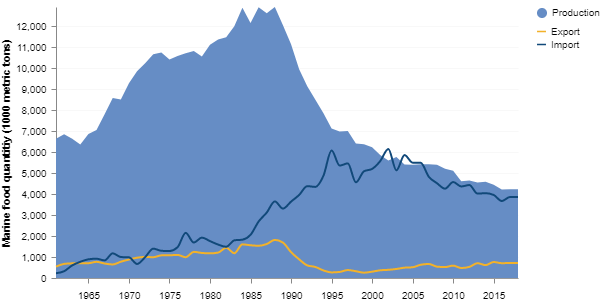

In [12]:
vega_view=dict(spec)

## DEFINE SIZE
vega_view['height'] = widget_height
vega_view['width'] = widget_width

## PARAMETERIZE WIDGET
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','ca5bfde08587530e76c17fe48362a01d')

## ADJUST X AXIS
vega_view['axes'][0]['labelBaseline']= "top"

## FONT
vega_view['axes'][1]['titleFont'] = 'Arial'
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][0]['titleFont'] = 'Arial'

Vega(vega_view)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

[foo.061.rw0 Food from the Sea](https://resourcewatch.org/data/explore/foo061rw0-Blue-Food-Supply) ([Admin](https://resourcewatch.org/admin/data/datasets/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/edit))  
`9e1b3cad-db6f-44b0-b6fb-048df7b6c680`  
[Dataset](https://api.resourcewatch.org/v1/dataset/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/), [Widgets](https://api.resourcewatch.org/v1/dataset/9e1b3cad-db6f-44b0-b6fb-048df7b6c680/widget)

In [5]:
dataset_id = '9e1b3cad-db6f-44b0-b6fb-048df7b6c680'
name = 'Production, Export, and Import of Marine Food'
description = 'Time series volumes (by weight) of production, export, and import of food originating in the sea, by country'

- [Country](https://api.resourcewatch.org/v1/widget/a9c33b55-494c-4984-8bfd-0f5b008dcf24?env=production) `a9c33b55-494c-4984-8bfd-0f5b008dcf24`  